In [1]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [2]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d import tiff_utils as tfu
from suite3d import file_utils as flu
from suite3d import nbtools as nbui
from suite3d import extension as ext

/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/paramiko/transport.py:258: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [12]:
tif_dir = '/mnt/md0/data/LAndau/ATL020-2023-03-29-701/701'
tifs = tfu.get_tif_paths(tif_dir)

In [224]:

vol_rate = 30 / 9
job_params = {   
    'lbm' : False,
    # number of channels recorded in the tiff file, typically 30
    'n_ch_tif' : 5,
    # convert from the Scanimage channel ordering to deep-to-shallow ordering
    # in our case, ScanImage channel numbers are in temporal order. 
    'planes' : n.arange(5),
    'multiplane_2p_use_planes' : n.array([0,1,2,3,4]),
    # number of files to use for the initial pass
    'n_init_files' :   3,

    # volume rate in acquisition
    'fs' : vol_rate,
    'lbm' : False,
    'subtract_crosstalk' : False,
    'fuse_strips' : False,
    
    # 3D GPU registration - fast! 
    # for now, 3D + GPU are well-tested, other options might have minor bugs
    # if you run into them, let us know! we'll fix them
    '3d_reg' : True,
    'gpu_reg' : True,
}

exp_str = 'HC-ATL020-2023-03-29-701'
savedir = os.path.join('/mnt/md0/runs', exp_str)
os.makedirs(savedir, exist_ok=True)

# Create the job
job = Job('/mnt/md0/runs',exp_str, tifs = tifs,
          params=job_params, create=True, overwrite=True, verbosity = 3)

Job directory /mnt/md0/runs/s3d-HC-ATL020-2023-03-29-701 already exists
Loading job directory for HC-ATL020-2023-03-29-701 in /mnt/md0/runs
   Loading dirs 
      Found dir registered_fused_data
      Found dir summary
      Found dir iters
   Loading default params
      Updating param lbm
      Updating param n_ch_tif
      Updating param planes
      Updating param multiplane_2p_use_planes
      Updating param n_init_files
      Updating param fs
      Updating param subtract_crosstalk
      Updating param fuse_strips
      Updating param 3d_reg
      Updating param gpu_reg
   Updated main params file


In [225]:
import tifffile

In [226]:
piezo = n.load(os.path.join(tif_dir, 'piezoPosition.raw.npy'))
frames = n.load(os.path.join(tif_dir, 'neuralFrames.raw.npy'))[:,0]

frames = n.where(n.diff(frames) > 0)

In [227]:

# xlim = (3900,4700)
# plt.plot(piezo[:1000000])
# plt.xlim(*xlim)
# for i in range(20):
#     if i % 5 == 0:
#         color='k'
#     else:
#         color='grey'
#     plt.axvline(frames[0][i], color=color)
# # plt.xlim(10000, 11000)
# plt

In [228]:
from suite3d.io.s3dio import s3dio

In [229]:
io = s3dio(job)

m0 = io.load_data(tifs[:1],)
v0 = m0[:,:].mean(axis=1)
m1 = io.load_data(tifs[1:2],)
v1 = m1[:,:].mean(axis=1)

      Loading tiff 1/1: /mnt/md0/data/LAndau/ATL020-2023-03-29-701/701/2023-03-29_701_ATL020_2P_00001_00001.tif
   Loaded 1 files, total 1.95 GB
      Loading tiff 1/1: /mnt/md0/data/LAndau/ATL020-2023-03-29-701/701/2023-03-29_701_ATL020_2P_00001_00002.tif
   Loaded 1 files, total 1.95 GB


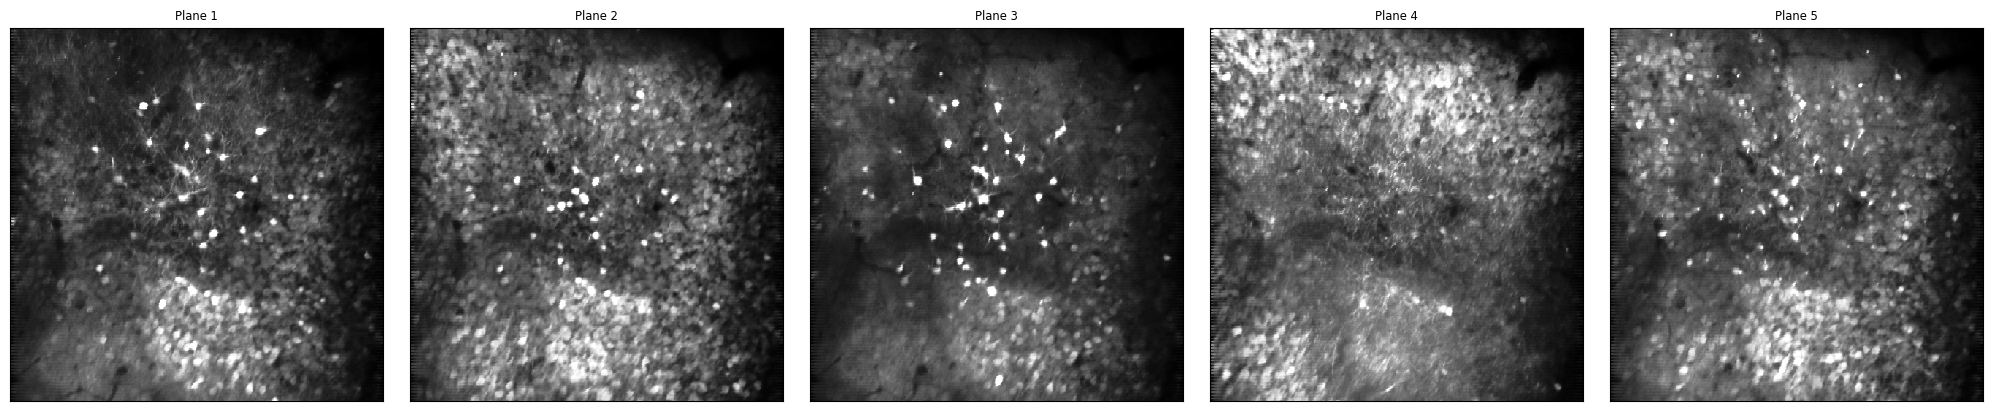

In [232]:
tfu.show_tif_all_planes(v0, ncols=len(v0), dpi=300, figsize=(20,4))

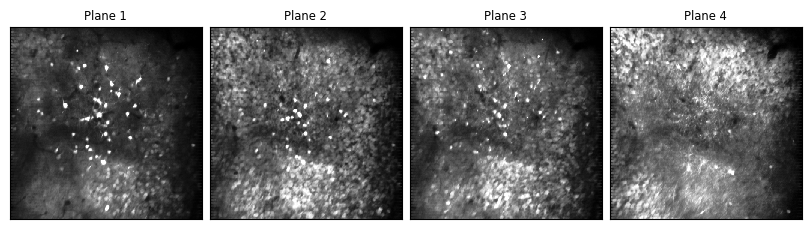

In [152]:
tfu.show_tif_all_planes(v1, ncols=len(v1))

In [153]:
job.run_init_pass()
summary = job.load_summary()

   Saved a copy of params at /mnt/md0/runs/s3d-HC-ATL020-2023-03-29-701/summary
   Updated main params file
Launching initial pass
Saving summary to /mnt/md0/runs/s3d-HC-ATL020-2023-03-29-701/summary/summary.npy
   Loading init tifs with 5 channels
      Loading tiff 1/3: /mnt/md0/data/LAndau/ATL020-2023-03-29-701/701/2023-03-29_701_ATL020_2P_00001_00010.tif
      Loading tiff 2/3: /mnt/md0/data/LAndau/ATL020-2023-03-29-701/701/2023-03-29_701_ATL020_2P_00001_00020.tif
      Loading tiff 3/3: /mnt/md0/data/LAndau/ATL020-2023-03-29-701/701/2023-03-29_701_ATL020_2P_00001_00030.tif
   Loaded 3 files, total 4.69 GB
   Selecting 500 random frames from the init tif files
   Loaded movie with 500 frames and shape 4, 512, 512
      Enforcing positivity in mean image
   No crosstalk estimation or subtraction
   Using 3d registration
   Computing plane alignment shifts
   Applying plane alignment shifts
   Launching 3D GPU reference image calculation
      Seeding reference image with most active

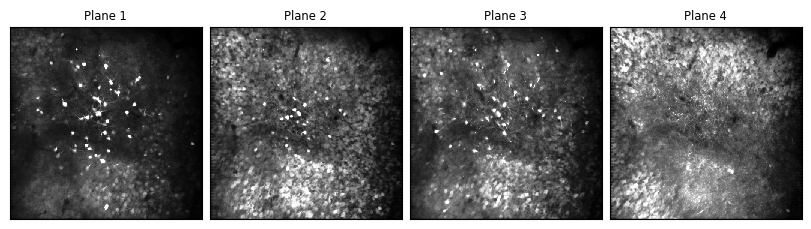

In [154]:
tfu.show_tif_all_planes(summary['ref_img_3d'], ncols=4)

In [158]:

job.dirs['registered_fused_data']

'/mnt/md0/runs/s3d-HC-ATL020-2023-03-29-701/registered_fused_data'

In [160]:
job.register(tifs = job.tifs[:10])

   Created dir /mnt/md0/runs/s3d-HC-ATL020-2023-03-29-701/registered_fused_data with tag registered_fused_data
      Updating self.dirs tag registered_fused_data
   Saved a copy of params at /mnt/md0/runs/s3d-HC-ATL020-2023-03-29-701/registered_fused_data
   Updated main params file
   Starting registration: 3D: True, GPU: True
   Not clipping frames for registration
Will analyze 10 tifs in 10 batches
   Enforcing positivity
   Launching IO thread
         Memory at batch 0.  Total Used: 156.124 GB, Virtual Available: 347.071 GB, Virtual Used: 156.124 GB, Swap Used: 000.000 GB
Loading Batch 0 of 9
      Loading tiff 1/1: /mnt/md0/data/LAndau/ATL020-2023-03-29-701/701/2023-03-29_701_ATL020_2P_00001_00001.tif
   Loaded 1 files, total 1.56 GB
   Batch 0 IO thread joined
         Memory after IO thread joinTotal Used: 157.693 GB, Virtual Available: 345.502 GB, Virtual Used: 157.693 GB, Swap Used: 000.000 GB
         Memory after movie copied from threadTotal Used: 159.259 GB, Virtual Avail

/home/ali/packages/s2p-lbm/suite3d/quality_metrics.py:41: RuntimeWarning: invalid value encountered in divide
  dff = df / fs.mean(axis=1,keepdims=True)
/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


         Saved in 0.28 sec
      Computing quality metrics and saving
      Saving fused, registered file of shape (4, 100, 512, 512) to /mnt/md0/runs/s3d-HC-ATL020-2023-03-29-701/registered_fused_data/fused_reg_data0002.npy
         Saved in 0.27 sec
      Computing quality metrics and saving
      Saving fused, registered file of shape (4, 100, 512, 512) to /mnt/md0/runs/s3d-HC-ATL020-2023-03-29-701/registered_fused_data/fused_reg_data0003.npy
         Saved in 0.27 sec
      Computing quality metrics and saving
      Saving fused, registered file of shape (4, 100, 512, 512) to /mnt/md0/runs/s3d-HC-ATL020-2023-03-29-701/registered_fused_data/fused_reg_data0004.npy
         Saved in 0.27 sec
      Computing quality metrics and saving
      Saving fused, registered file of shape (4, 100, 512, 512) to /mnt/md0/runs/s3d-HC-ATL020-2023-03-29-701/registered_fused_data/fused_reg_data0005.npy
         Saved in 0.27 sec
      Computing quality metrics and saving
      Saving fused, registered

In [161]:
mov = job.get_registered_movie()

In [167]:
job.params['voxel_size_um'] = (15,1,1)

In [188]:
job.params['cell_filt_xy_um'] = 2.5
job.params['cell_filt_type'] = 'gaussian'
job.params['cell_filt_z_um']  = 5

In [197]:
job.params['intensity_thresh'] = 2.0

In [198]:
# job.params['npil_filt_xy_um'] = 30
corrmap = job.calculate_corr_map(iter_limit = 5)

      Found dir /mnt/md0/runs/s3d-HC-ATL020-2023-03-29-701/corrmap
      Updating self.dirs tag corrmap
      Found dir /mnt/md0/runs/s3d-HC-ATL020-2023-03-29-701/mov_sub
      Updating self.dirs tag mov_sub
   Saved a copy of params at /mnt/md0/runs/s3d-HC-ATL020-2023-03-29-701/corrmap
   Updated main params file
   Computing correlation map of movie with 8000 frames, volume shape: 4, 512, 512
      Running batch 1 of 5
         Timer prep completed in 0.594 sec
         Timer batch_setup completed in 0.190 sec
         Timer batch_edgecrop completed in 0.035 sec
         Timer accum_meanmeax completed in 0.164 sec
         Timer batch_rolling_mean_filt completed in 0.157 sec
         Timer batch_accum_sdmov completed in 0.476 sec
         Timer batch_norm_sdmov completed in 0.083 sec
         Loading movie into shared memory
         Timer dtu_shmem completed in 0.643 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 1.732 sec
  

In [204]:
corr_map = job.load_corr_map_results()['vmap']
corr_map_thresh = ext.thresh_mask_corr_map(corr_map, thresh_window_size_pix = 51, corrmap_thresh_pct = 50)

# most important parameter - any value of the corrmap
# above this will be considered a peak for a possible ROI,
# and will be used as a "seed" to grow an ROI around it
# bigger number: fewer ROIs, only bright ones
# smaller number: many ROIs, increasingly worse quality
job.params['peak_thresh'] =  0.3

# optionally, bin the movie in time to speed up detection
# probably a good idea if you have high framerate (>5 Hz?)
job.params['detection_timebin'] = 1 
job.params['n_proc_detect'] = 64
# when extending an ROI, compare its activity to its neighboring pixels
# in frames where the fluorescence is above this percentile
job.params['percentile'] = 99.5
job.params['activity_thresh'] = 2.0
job.params['patch_size_xy'] = 600, 600


job.segment_rois(vmap = corr_map_thresh)

      Found dir /mnt/md0/runs/s3d-HC-ATL020-2023-03-29-701/segmentation
      Updating self.dirs tag segmentation
   Saved a copy of params at /mnt/md0/runs/s3d-HC-ATL020-2023-03-29-701/segmentation
   Updated main params file
      Found dir /mnt/md0/runs/s3d-HC-ATL020-2023-03-29-701/rois
      Updating self.dirs tag rois
   Saving results to /mnt/md0/runs/s3d-HC-ATL020-2023-03-29-701/segmentation and /mnt/md0/runs/s3d-HC-ATL020-2023-03-29-701/rois 
dict_keys(['max_img', 'mean_img', 'vmap', 'all_params'])
   Detecting from patch 1 / 1
      Found dir /mnt/md0/runs/s3d-HC-ATL020-2023-03-29-701/segmentation/patch-0000
         Loading 3.91 GB movie to memory, shape: (2000, 4, 512, 512) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 0.300 and Th2: 2.000
         Iter 0000: running 64 ROIs in parallel
         Added cell 1 at 01, 452, 470, peak: 0.938, thresh: 2.000, 116 frames, 129 pixels
         Added cell 2 at

'/mnt/md0/runs/s3d-HC-ATL020-2023-03-29-701/rois'

In [206]:
seg = job.load_segmentation_results()

      Loading from /mnt/md0/runs/s3d-HC-ATL020-2023-03-29-701/rois/info.npy
      Loading from /mnt/md0/runs/s3d-HC-ATL020-2023-03-29-701/rois/stats.npy
      Loading from /mnt/md0/runs/s3d-HC-ATL020-2023-03-29-701/rois/iscell.npy


In [208]:
import colorcet

In [212]:
from pathlib import Path

In [213]:
fig_dir = Path('/mnt/md0/s3d-figures')
figname = 'fig_hc'
fdir = fig_dir / figname
plt.rcParams['svg.fonttype'] = 'none'
os.makedirs(fdir, exist_ok=True)

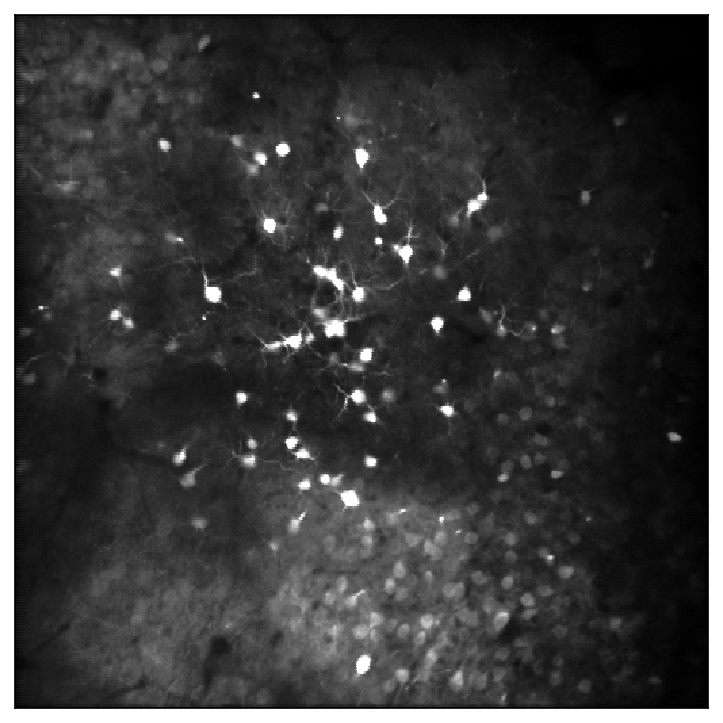

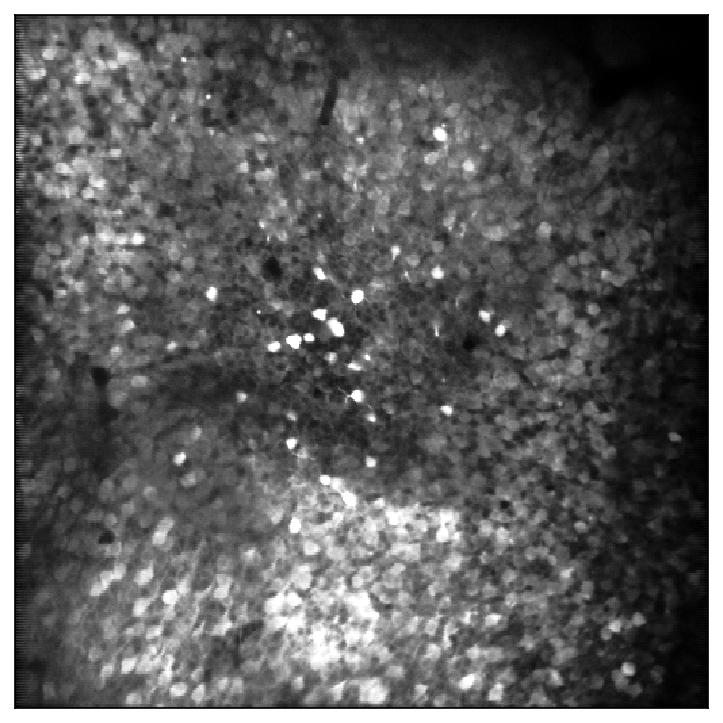

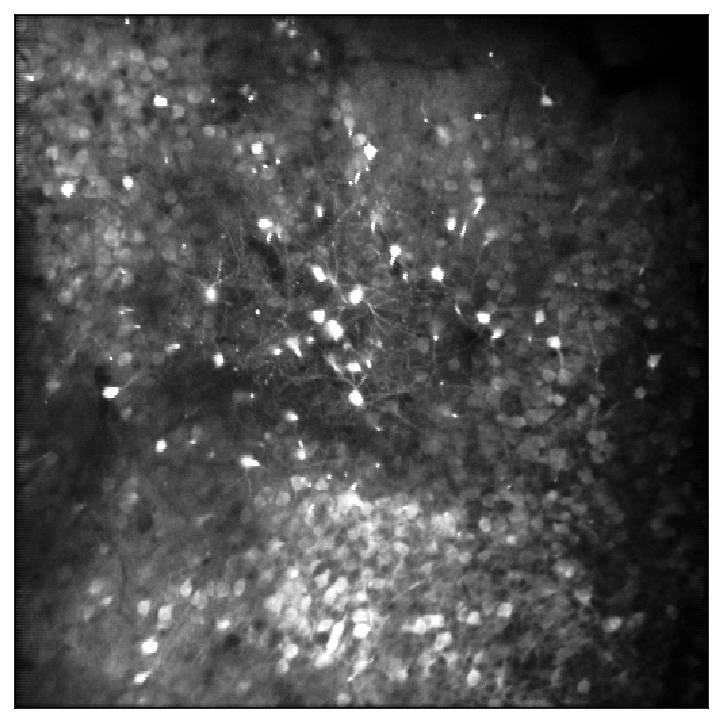

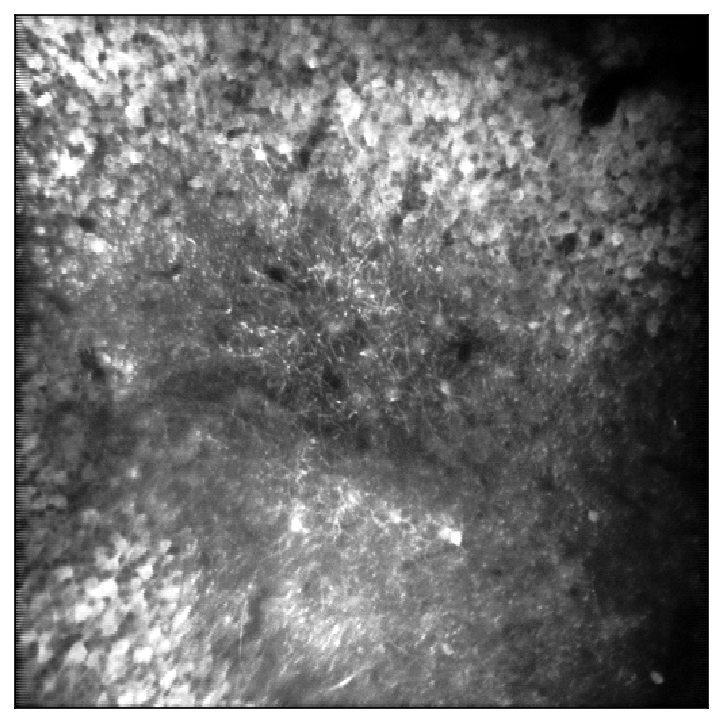

In [221]:
for i in range(len(summary['ref_img_3d'])):
    tfu.show_tif(summary['ref_img_3d'][i])
    plt.savefig(os.path.join(fdir, 'plane%d.svg' % i), bbox_inches='tight', pad_inches=0, dpi=200)

In [220]:
# filt = npix > -1
filt = n.ones(len(seg['stats']))

n_files = 8
shuff_cells = n.where(filt)[0]
n.random.shuffle(shuff_cells)
nc = len(shuff_cells)
batchsize = nc // n_files
for i in range(n_files):
    cx = shuff_cells[i*batchsize:i*batchsize + batchsize]
    filefilt = n.zeros_like(filt)
    filefilt[cx] = True

    __, filevol = ui.make_label_vols(seg['stats'], corr_map.shape, lam_max=1.0, cmap='cet_glasbey_dark',
                                             iscell = filefilt)
    tfu.save_mrc(figname,os.path.join(fdir, f'landau_HC_{i:02d}.mrc'), filevol[:,:,:,-1],
            voxel_size=(1, 1, 15))